In [1]:
## Imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
current_directory = os.getcwd()


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

print(current_directory)


/Users/ssachd/Library/CloudStorage/OneDrive-Personal/LighGB ML/Model


In [2]:
## Dataframe
file_name = 'Mean_RockSiteInjection.xlsx'
data_rock= pd.read_excel(f"CSVs/ML_Inputs/{file_name}",sheet_name="Mean_All")


In [ ]:
## Matricies
# Keep only numeric columns
data_num_rock= data_rock.select_dtypes(include=['number'])
data_num_rock = data_num_rock.drop(columns=['Vertical Stress (Surface Value)','Horizontal Stress (Surface Value)','Pore Pressure (Surface Value)','Horizontal Stress Gradient','Vertical Stress Gradient','Pore Pressure Gradient','Horizontal Stress','Overburden Stress'])
#data_num_inj= data_inj.select_dtypes(include=['number'])
# Corelation matrix 
corel_rock = data_num_rock.corr(method='spearman')
#corel_inj = data_num_inj.corr(method='spearman')



KeyError: "['Vertical Stress'] not found in axis"

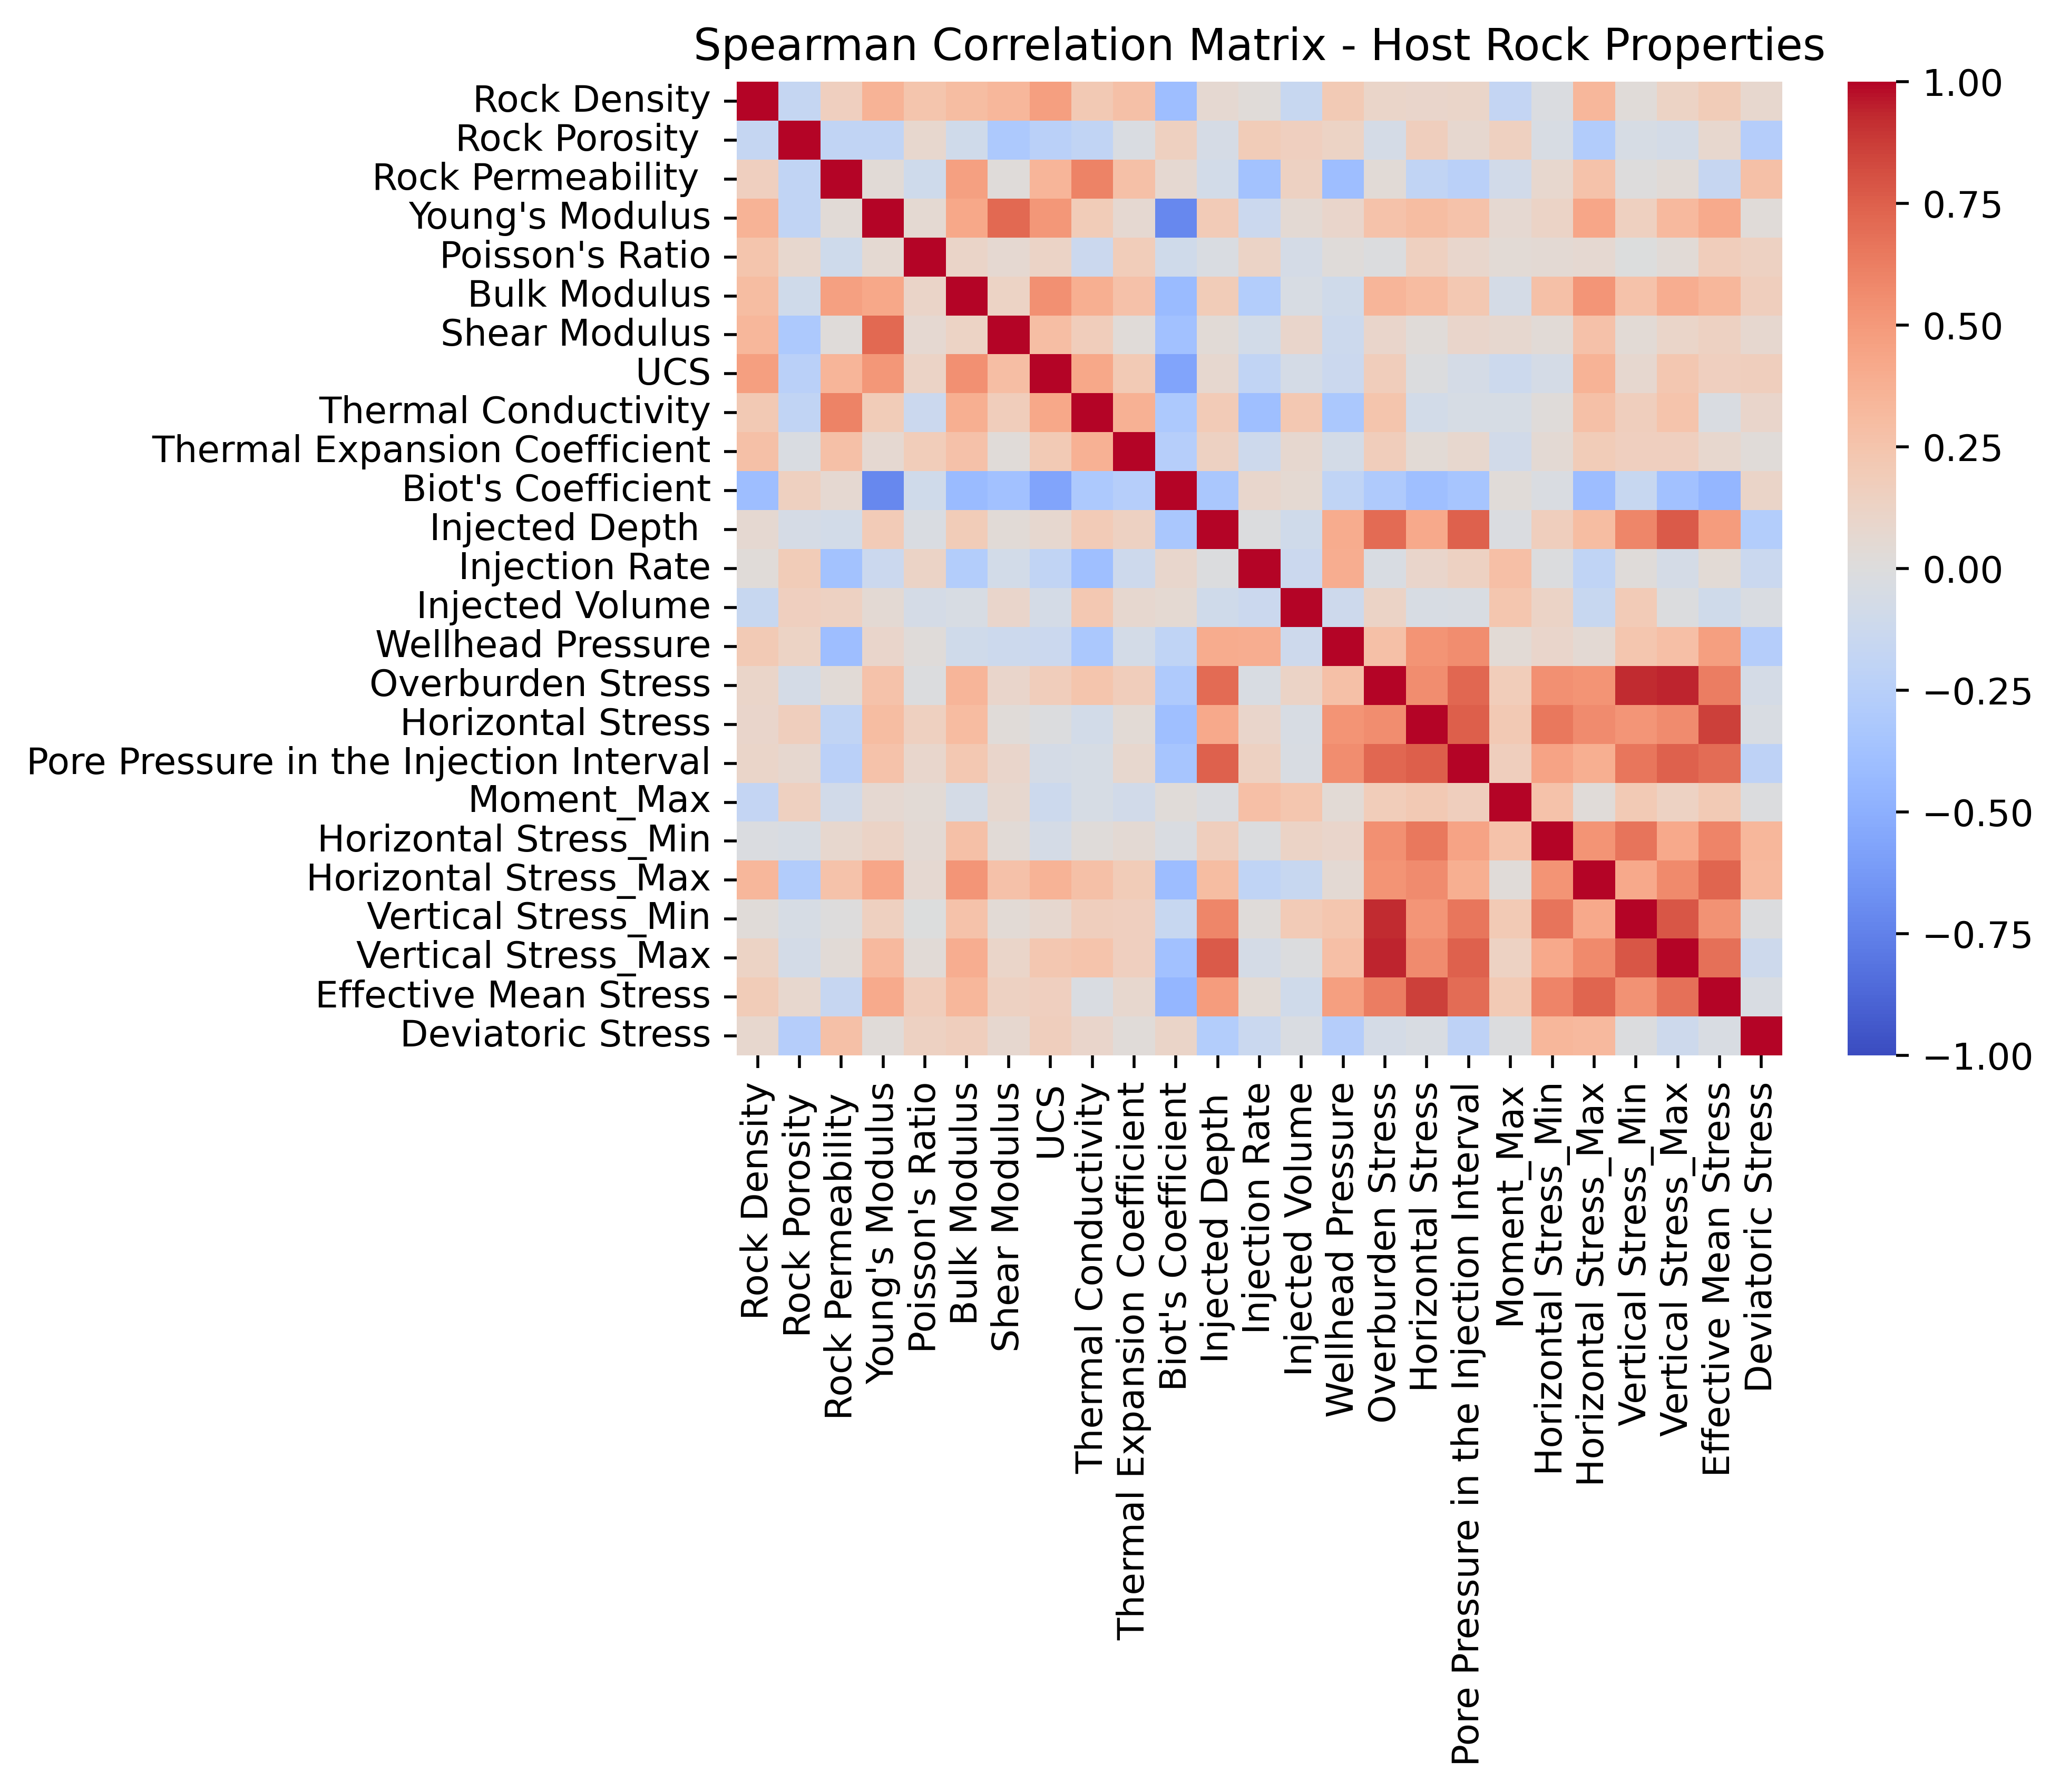

In [ ]:
plt.figure(dpi=500)
sns.heatmap(corel_rock, cmap='coolwarm', cbar=True,vmin=-1,vmax=1)

plt.title('Spearman Correlation Matrix - Host Rock Properties')
file_path = "PNGs/Host Rock Properties and Moment_Max.jpg"
plt.savefig(file_path, format='jpg',bbox_inches='tight')
plt.show()
plt.close()






                                    feature  correlation  correlation_norm
0                            Injection Rate     0.284771          1.000000
1                     Horizontal Stress_Min     0.260277          0.913986
2                           Injected Volume     0.239587          0.841331
3                         Horizontal Stress     0.216645          0.760770
4                       Vertical Stress_Min     0.210450          0.739013
5                     Effective Mean Stress     0.205560          0.721843
6                         Overburden Stress     0.184141          0.646629
7   Pore Pressure in the Injection Interval     0.165060          0.579624
8                            Rock Porosity      0.150677          0.529116
9                       Vertical Stress_Max     0.133145          0.467550
10                            Shear Modulus     0.076745          0.269499
11                          Young's Modulus     0.065523          0.230091
12                       

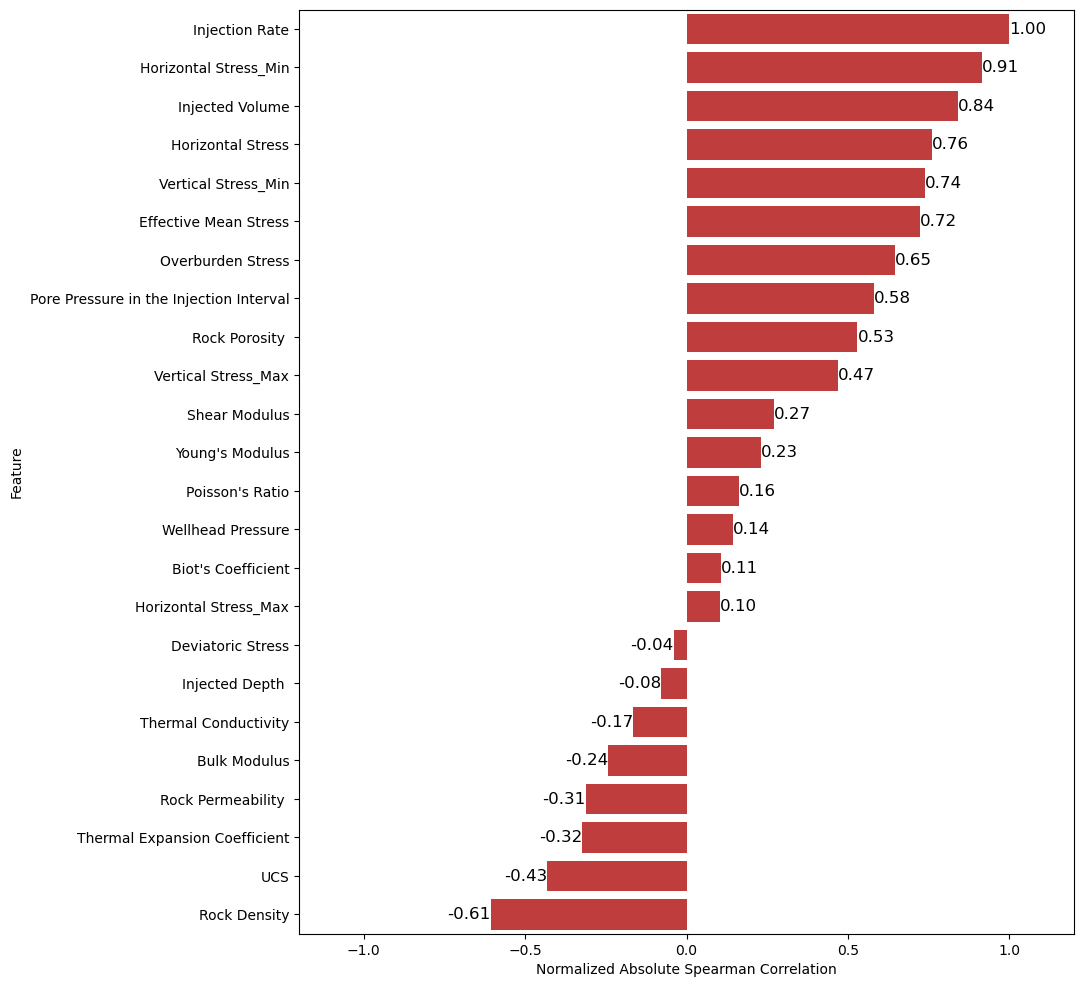

In [10]:
import numpy as np

# Extract correlations for the target variable
target_var = 'Moment_Max'
correlations = corel_rock[target_var].drop(target_var, errors='ignore')

# Normalize: absolute value, then scale 0–1
correlations_abs = correlations.abs()
correlations_norm = correlations / correlations.max()

# Combine into DataFrame
correlations_df = correlations.reset_index()
correlations_df.columns = ['feature', 'correlation']
correlations_df['correlation_norm'] = correlations_norm.values

# Sort by normalized value (descending)
correlations_df = correlations_df.sort_values(by='correlation_norm', ascending=False).reset_index(drop=True)
print(correlations_df)

# Plot normalized values instead
plt.figure(figsize=(10, 12))
bar_plot = sns.barplot(
    x='correlation_norm', 
    y='feature', 
    data=correlations_df, 
    color="#d62728",
)

# Add annotations for the normalized correlation values
for index, row in correlations_df.iterrows():
    bar_plot.text(row['correlation_norm'], 
                  index, 
                  f"{row['correlation_norm']:.2f}", 
                  color='black', 
                  ha="left" if row['correlation'] > 0 else "right", 
                  va="center", 
                  fontsize=12)

# x-axis: 0 to 1 for normalized scale
plt.xlim(-1.2, 1.2)

plt.xlabel('Normalized Absolute Spearman Correlation')
plt.ylabel('Feature')

# Save
file_path = f"PNGs/Feature_Normalized_Correlations_with_{target_var}.jpg"
plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=300)

plt.show()


In [9]:
## Random Forrest 


def advanced_impute_with_random_forest(df):
    df_filled = df.copy()
    
    # Hyperparameters for GridSearch
    param_grid = {
        'n_estimators': [50, 100], 
        'max_depth': [None, 10],   
        'min_samples_split': [2],   
        'min_samples_leaf': [1]     
    }
    
    # Minimum samples required for training RandomForest
    min_samples_for_training = 5  
    insufficient_data_columns = []
    # Imputer for features with missing values
    feature_imputer = SimpleImputer(strategy="mean")

    for column in df.columns:
        if df_filled[column].isnull().any():
            # Separate data into training and testing sets
            df_train = df_filled[df_filled[column].notnull()]
            df_test = df_filled[df_filled[column].isnull()]

            # Drop rows with NaNs or infinities in the training set
            X_train = df_train.drop(columns=[column]).replace([np.inf, -np.inf], np.nan)
            y_train = df_train[column]

            # Remove columns with all NaN values
            X_train_non_na = X_train.loc[:, X_train.notna().any()]
            X_test_non_na = df_test.drop(columns=[column]).replace([np.inf, -np.inf], np.nan).loc[:, X_train_non_na.columns]

            # Apply SimpleImputer to ensure there are no NaN values
            try:
                X_train_imputed = pd.DataFrame(
                feature_imputer.fit_transform(X_train_non_na),
                columns=X_train_non_na.columns
                )
            except ValueError as e:
                print("ValueError during imputation:", e)
            X_train_imputed = pd.DataFrame(
                feature_imputer.fit_transform(X_train_non_na),
                columns=X_train_non_na.columns
            )
            X_test_imputed = pd.DataFrame(
                feature_imputer.transform(X_test_non_na),
                columns=X_test_non_na.columns
            )

            # Check if there’s enough data for training
            if len(y_train) >= min_samples_for_training:
                try:
                    # Define model and GridSearchCV for hyperparameter tuning
                    model = RandomForestRegressor(random_state=0)
                    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
                    grid_search.fit(X_train_imputed, y_train)

                    # Best model after grid search
                    best_model = grid_search.best_estimator_

                    # Predict and fill missing values if test set is non-empty
                    if not X_test_imputed.empty:
                        df_filled.loc[df_filled[column].isnull(), column] = best_model.predict(X_test_imputed)
                    print(f"Random Forest imputation done for column: {column}")

                except ValueError as e:
                    print(f"Skipping column '{column}' due to error: {e}")

            # Use Conditional Mean/Median Imputation if insufficient data for Random Forest
            elif not y_train.empty:
                mean_value = y_train.mean()  # Use mean (or median as needed)
                df_filled[column].fillna(mean_value, inplace=True)
                insufficient_data_columns.append(column)
                print(f"Imputed column '{column}' with mean value: {mean_value:.2f} due to insufficient data.")
    # Save the list of columns imputed due to insufficient data 
    with open('insufficient_data_columns.txt', 'w') as f: 
        for col in insufficient_data_columns: 
            f.write(f"{col}\n")
    return df_filled




In [ ]:
## Interpolation-3
data_forest = advanced_impute_with_random_forest(data_num_inj)
data_forest.to_excel("CSVs\ML_Outputs\Imputed_InjectionData.xlsx", sheet_name='Imputed_Injections')


In [ ]:
## Heat Maps : Correlation of Interploated matrix 

# Compute correlation matrices
orig = data_num.corr()
median = data_median.corr()
knn = data_knn.corr()
rf = data_forest.corr()

# List of correlation matrices and titles for each imputation method
corr_matrices = [median, knn,rf, orig]
titles = ['Median Imputation', 'KNN Imputation', 'Random Forest Imputation', 'Original']

# Plot and save each heatmap individually
for i, (corr_matrix, title) in enumerate(zip(corr_matrices, titles)):
    plt.figure(dpi=100)  # Set the figure size for each heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, cbar=True)
    plt.title(title)
    
    # Show the plot
    plt.show()

    # Save the figure as a separate JPG file
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{title.replace(" ", "_").lower()}.jpg', format='jpg')  # Save with a specific name
    
    plt.close()  # Close the current plot to avoid overlap in the next iteration

print("All heatmaps have been displayed and saved as separate images.")




In [ ]:
## Heat Maps: Interpolated Correlated matrix. 



# Compute correlation matrices
orig = corel_num
median = corel_median
knn = corel_knn
#rf = corel_forest

# List of correlation matrices and titles for each imputation method
corr_matrices = [median, knn, orig]
titles = ['Median Imputation', 'KNN Imputation', 'Random Forest Imputation', 'Original']

# Plot and save each heatmap individually
for i, (corr_matrix, title) in enumerate(zip(corr_matrices, titles)):
    plt.figure(dpi=100)  # Set the figure size for each heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, cbar=True)
    plt.title(title)
    
    # Show the plot
    plt.show()

    # Save the figure as a separate JPG file
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{title.replace(" ", "_").lower()}.jpg', format='jpg')  # Save with a specific name
    
    plt.close()  # Close the current plot to avoid overlap in the next iteration

print("All heatmaps have been displayed and saved as separate images.")

In [ ]:


# Function to compute correlations and p-values
def calculate_correlations_with_p_values(df, specific_var):
    correlations = {}
    p_values = {}

    for col in df.columns:
        if col != specific_var:  # Avoid self-correlation
            corr, p_val = pearsonr(df[col].dropna(), df[specific_var].dropna())  # Handle NaNs
            correlations[col] = corr
            p_values[col] = p_val

    # Create a DataFrame for correlations and p-values
    result_df = pd.DataFrame({
        'correlation': correlations,
        'p_value': p_values
    })

    # Filter by p-value threshold (e.g., 0.05 for significance)
    result_df = result_df[result_df['p_value'] < 0.5]

    # Sort by absolute correlation values and select top 10
    result_df = result_df.reindex(result_df['correlation'].abs().sort_values(ascending=False).index).head(20)

    return result_df

# Specific variable of interest
specific_var = 'moment_max'

# Calculate correlations and p-values for data_forest
correlations_df = calculate_correlations_with_p_values(data_forest, specific_var)

# Calculate correlations and p-values for corel_forest
correlations_df_corel = calculate_correlations_with_p_values(corel_forest, specific_var)

# Plot heatmap for data_forest
plt.figure(figsize=(8, 5))
plt.title(f"Rock+Injection Correlations with '{specific_var}' - (p < 0.5)")
sns.heatmap(
    correlations_df[['correlation']],
    annot=True,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5,
    vmin=-1,  # Minimum value of the color scale
    vmax=1    # Maximum value of the color scale
)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')

# Plot heatmap for corel_forest
plt.figure(figsize=(8, 5))
plt.title(f"Rock+Injection Correlations with '{specific_var}' - (p < 0.5)")
sns.heatmap(
    correlations_df_corel[['correlation']],
    annot=True,
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5,
    vmin=-1,  # Minimum value of the color scale
    vmax=1    # Maximum value of the color scale
)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()





In [ ]:
## Heat map for selected parameters
headers_rf = data_forest.columns.tolist()

rock_headers = [header for header in headers_rf if header.startswith('rock')] 
site_headers = [header for header in headers_rf if header.startswith('site')]
fault_headers = [header for header in headers_rf if header.startswith('fault')] 
inj_headers = [header for header in headers_rf if header.startswith('inj')]
seis_headers = [header for header in headers_rf if header.startswith('seis')] 
moment_headers = ['moment_max']

data_rock = data_forest.filter(items=rock_headers+moment_headers)
data_site = data_forest.filter(items=site_headers+moment_headers)
data_inj = data_forest.filter(items=inj_headers+moment_headers)
data_fault = data_forest.filter(items=fault_headers+moment_headers)
data_seis = data_forest.filter(items=seis_headers+moment_headers)


data_rock.to_csv("CSVs\data_rock.csv", index=False)
data_site.to_csv("CSVs\data_site.csv", index=False)
data_inj.to_csv("CSVs\data_inj.csv", index=False)
data_fault.to_csv("CSVs\data_fault.csv", index=False)
data_seis.to_csv("CSVs\data_seis.csv", index=False)

In [ ]:
## Heat Maps : Correlation of seleccted matrix 


# Compute correlation matrices
rock = data_rock.corr()
site = data_site.corr()
inj = data_inj.corr()
seis = data_seis.corr()
fault = data_fault.corr()

# List of correlation matrices and titles for each imputation method
corr_matrices = [rock,site,inj,seis,fault]
titles = ['ROCK', 'SITE', 'INJ', 'SEIS','FAULT']

# Plot and save each heatmap individually
for i, (corr_matrix, title) in enumerate(zip(corr_matrices, titles)):
    plt.figure(dpi=100)  # Set the figure size for each heatmap
    sns.heatmap(corr_matrix,cmap='coolwarm',cbar=True)
    plt.title(title)
    
    # Show the plot
    plt.show()

    # Save the figure as a separate JPG file
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{title.replace(" ", "_").lower()}.jpg', format='jpg')  # Save with a specific name
    
    plt.close()  # Close the current plot to avoid overlap in the next iteration

print("All heatmaps have been displayed and saved as separate images.")

In [ ]:


# Define the specific variable of interest
specific_var = 'moment_max'

# Function to compute correlations and p-values
def calculate_correlations_with_p_values(data, specific_var):
    correlations = {}
    p_values = {}

    for col in data.columns:
        if col != specific_var:  # Avoid self-correlation
            corr, p_val = pearsonr(data[col].dropna(), data[specific_var].dropna())  # Handle NaNs
            correlations[col] = corr
            p_values[col] = p_val

    # Create a DataFrame for correlations and p-values
    result_df = pd.DataFrame({
        'correlation': correlations,
        'p_value': p_values
    })

    # Filter by p-value threshold (e.g., 0.05 for significance)
    result_df = result_df[result_df['p_value'] < 0.05]

    # Sort by absolute correlation values and select the top 7
    result_df = result_df.reindex(result_df['correlation'].abs().sort_values(ascending=False).index).head(7)

    return result_df

# List of datasets and their titles
datasets = [
    (data_rock, 'data_rock'),
    (data_site, 'data_site'),
    (data_inj, 'data_inj'),
    (data_seis, 'data_seis'),
    (data_fault, 'data_fault')
]

# Create subplots for the heatmaps
num_datasets = len(datasets)
fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 6), constrained_layout=True)

# Plot each heatmap
for ax, (data, title) in zip(axes, datasets):
    correlations_df = calculate_correlations_with_p_values(data, specific_var)
    
    if correlations_df.empty:
        ax.text(0.5, 0.5, f'No significant\ncorrelations\n(p < 0.05)', 
                horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(f"{title}\n(No significant variables)")
        ax.axis('off')
    else:
        sns.heatmap(
            correlations_df[['correlation']],
            annot=True,
            cmap='coolwarm',
            cbar=True,
            linewidths=0.5,
            vmin=-1,
            vmax=1,
            ax=ax
        )
        ax.set_title(f"Top 7 Correlations with '{specific_var}'\n{title}")
        ax.set_xlabel('Correlation Coefficient')
        ax.set_ylabel('Variables')

plt.suptitle(f"Top 7 Significant Correlations with '{specific_var}' (p < 0.05) Across Datasets", fontsize=16)
plt.show()
